In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("makemore/names.txt", "r").read().splitlines()
words[0:3]

['emma', 'olivia', 'ava']

In [3]:
# Build vocabulary and mappings
chars = sorted(list(set("".join(words))))
stoi = {c: i + 1 for i, c in enumerate(chars)}
stoi["."] = 0
itos = {c: i for i, c in stoi.items()}

In [4]:
# Build dataset

block_size = 3  # Number of characters to look back.
X, Y = [], []

for w in words:
    # print(f"{w=}")

    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(f"{"".join([itos[i] for i in context])} ---> {itos[ix]}")
        context = context[1:] + [ix]  # Crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
# Each example is an input vector of size 3 and a label of 1 index.
# First 5 words produce 32 examples

print(X.shape, Y.shape)
print(f"Example {X[3]} => {Y[3]}")

torch.Size([228146, 3]) torch.Size([228146])
Example tensor([ 5, 13, 13]) => 1


In [6]:
# Hyper Parameters
CONTEXT = 3  # Context window
VOCAB = 27  # Size of vocab
EMBED = 2  # Size of embedding vector
L1 = 100  # Size of hidden layer
MSIZE = 32  # Size of mini batch

In [7]:
X.shape[0]  # Number of examples

228146

In [8]:
g = torch.Generator().manual_seed(2147483647)

# Embedding table C. 27 tokens, each embedding only 2 dimensions long.
C = torch.randn((VOCAB, EMBED), requires_grad=True, generator=g)

# Hidden layer. Each neuron connected to weights in concatenated input embedding
W1 = torch.randn((CONTEXT * EMBED, L1), requires_grad=True, generator=g)
b1 = torch.randn(L1, requires_grad=True, generator=g)

# Output layer. Inputs match the output of previous layer. One output for each word in vocab
W2 = torch.randn((L1, VOCAB), requires_grad=True, generator=g)
b2 = torch.randn(VOCAB, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

In [9]:
sum(p.nelement() for p in parameters)  # Number of parameters in total

3481

In [10]:
losses = []
steps = []

In [11]:
for i in range(200000):

    # ** Mini batch ***
    ix = torch.randint(0, X.shape[0], (MSIZE,))  # generator=g ?

    # ** Forward Pass **

    # emb maps each input to corresponding embedding vector
    emb = C[X[ix]]  # 🏆 👏, Good job there PyTorch.

    assert emb.shape == (MSIZE, CONTEXT, EMBED)

    # Output from hidden layer
    h = torch.tanh(emb.view(-1, CONTEXT * EMBED) @ W1 + b1)

    # Output layer + Softmax
    logits = h @ W2 + b2

    # Pluck out the right label from each vector and map to output
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    losses.append(loss.item())

    # ** Backward Pass **
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    steps.append(i)
    losses.append(loss.log10().item())

Text(0.5, 0, 'start=21.2114, end=0.3125')

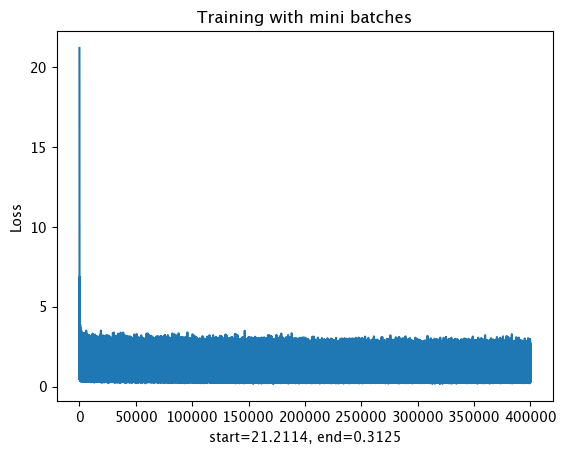

In [12]:
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training with mini batches")
plt.xlabel(f"start={losses[0]:.4f}, end={losses[-1]:.4f}")

In [13]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

careah.
ami.
havi.
kimri.
reh.
cahlanden.
jazhutefemerric.
kaqui.
nerania.
chaiiv.
kaleig.
dham.
joce.
quinn.
sroun.
alian.
quiquelo.
dearynix.
kaellinsle.
edde.
